In [61]:
import numpy as np

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist

import matplotlib.pyplot as plt
%matplotlib inline

import glob
import pandas as pd

from scipy.spatial.distance import euclidean
from numpy import array, zeros, argmin, inf, equal, ndim
from scipy.spatial.distance import cdist

from datetime import datetime

In [2]:
d1 = glob.glob('Datasets/digit_data/isolated/36/1/*')
d2 = glob.glob('Datasets/digit_data/isolated/36/2/*')
d3 = glob.glob('Datasets/digit_data/isolated/36/3/*')

In [3]:
def load_mfcc(list_paths):
    X = []
    for i in list_paths:
        X.append(np.array(pd.read_csv(i, sep = " ", skiprows = [0], header = None))[:,1:])

    return np.array(X)

def combine(X):
    temp_X = []

    for i in X:
        for j in i:
            temp_X.append(j)

    return np.array(temp_X)

In [59]:
# Load and structure data
X1 = load_mfcc(d1)
X2 = load_mfcc(d2)
X3 = load_mfcc(d3)

# Train Test data partition
X1_train,X1_test = train_test_split(X1, test_size=0.3, random_state=42)
X2_train,X2_test = train_test_split(X2, test_size=0.3, random_state=42)
X3_train,X3_test = train_test_split(X3, test_size=0.3, random_state=42)

X1_valid,X1_test = train_test_split(X1_test, test_size=0.4, random_state=42)
X2_valid,X2_test = train_test_split(X2_test, test_size=0.4, random_state=42)
X3_valid,X3_test = train_test_split(X3_test, test_size=0.4, random_state=42)

In [42]:
def _traceback(D):
    i, j = array(D.shape) - 2
    p, q = [i], [j]
    while ((i > 0) or (j > 0)):
        tb = argmin((D[i, j], D[i, j+1], D[i+1, j]))
        if (tb == 0):
            i -= 1
            j -= 1
        elif (tb == 1):
            i -= 1
        else: # (tb == 2):
            j -= 1
        p.insert(0, i)
        q.insert(0, j)
    return array(p), array(q)

In [43]:
def dtw(x, y, dist):
    """
    Computes Dynamic Time Warping (DTW) of two sequences.

    :param array x: N1*M array
    :param array y: N2*M array
    :param func dist: distance used as cost measure

    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:] # view
    for i in range(r):
        for j in range(c):
            D1[i, j] = dist(x[i], y[j])
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    if len(x)==1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return (D1[-1, -1] / sum(D1.shape), C, D1, path)

In [44]:
def fastdtw(x, y, dist):
    """
    Computes Dynamic Time Warping (DTW) of two sequences in a faster way.
    Instead of iterating through each element and calculating each distance,
    this uses the cdist function from scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.distance.cdist.html)

    :param array x: N1*M array
    :param array y: N2*M array
    :param string or func dist: distance parameter for cdist. When string is given, cdist uses optimized functions for the distance metrics.
    If a string is passed, the distance function can be 'braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 'mahalanobis', 'matching', 'minkowski', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'wminkowski', 'yule'.
    Returns the minimum distance, the cost matrix, the accumulated cost matrix, and the wrap path.
    """
    assert len(x)
    assert len(y)
    if ndim(x)==1:
        x = x.reshape(-1,1)
    if ndim(y)==1:
        y = y.reshape(-1,1)
    r, c = len(x), len(y)
    D0 = zeros((r + 1, c + 1))
    D0[0, 1:] = inf
    D0[1:, 0] = inf
    D1 = D0[1:, 1:]
    D0[1:,1:] = cdist(x,y,dist)
    C = D1.copy()
    for i in range(r):
        for j in range(c):
            D1[i, j] += min(D0[i, j], D0[i, j+1], D0[i+1, j])
    if len(x)==1:
        path = zeros(len(y)), range(len(y))
    elif len(y) == 1:
        path = range(len(x)), zeros(len(x))
    else:
        path = _traceback(D0)
    return (D1[-1, -1] / sum(D1.shape), C, D1, path)

In [45]:
from sklearn.metrics.pairwise import euclidean_distances
from nltk.metrics.distance import edit_distance
from sklearn.metrics.pairwise import manhattan_distances

#dist_fun = euclidean_distances

In [46]:
template = X1_train[0]
test = X1_train[0]
dist_fun = lambda template, test: np.linalg.norm(template - test, ord=1)

In [47]:
dist, cost, acc, path = fastdtw(template, test, dist_fun)

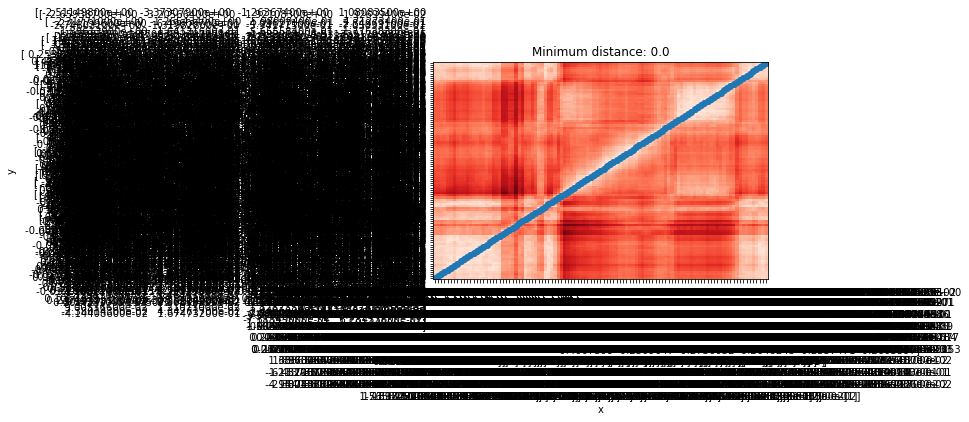

In [40]:
# vizualize

x = template
y = test

from matplotlib import pyplot as plt
plt.imshow(cost.T, origin='lower', cmap=plt.cm.Reds, interpolation='nearest')
plt.plot(path[0], path[1], '-o') # relation
plt.xticks(range(len(x)), x)
plt.yticks(range(len(y)), y)
plt.xlabel('x')
plt.ylabel('y')
plt.axis('tight')
plt.title('Minimum distance: {}'.format(dist))
plt.show()

In [144]:
startTime = datetime.now()

training_file = X3_train
validation_file = X3_valid

dist_matrix = np.zeros((validation_file.shape[0], training_file.shape[0]))

for x in range(validation_file.shape[0]):
    test_point = validation_file[x]
    for y in range(training_file.shape[0]):
        template_point = training_file[y]
        dist, cost, acc, path = fastdtw(template_point, test_point, dist_fun)
        dist_matrix[x][y] = dist
        
print(datetime.now() - startTime)

0:00:38.799041


In [145]:
tmp = dist_matrix
indices_with_min_dist = np.argsort(tmp)

In [146]:
from collections import Counter
for i in range(indices_with_min_dist.shape[0]):
    b = Counter(indices_with_min_dist[:, i])
    print(b)
    print(b.most_common(1))

Counter({8: 2, 20: 2, 16: 1, 27: 1, 5: 1, 9: 1, 22: 1, 15: 1})
[(8, 2)]
Counter({20: 2, 36: 2, 17: 1, 13: 1, 5: 1, 18: 1, 1: 1, 32: 1})
[(20, 2)]
Counter({31: 2, 37: 2, 28: 1, 20: 1, 8: 1, 19: 1, 4: 1, 9: 1})
[(31, 2)]
Counter({4: 2, 31: 2, 37: 1, 6: 1, 23: 1, 13: 1, 2: 1, 30: 1})
[(4, 2)]
Counter({15: 3, 32: 2, 38: 1, 29: 1, 20: 1, 25: 1, 6: 1})
[(15, 3)]
Counter({36: 2, 27: 2, 22: 1, 37: 1, 6: 1, 13: 1, 35: 1, 17: 1})
[(36, 2)]
Counter({17: 2, 29: 1, 0: 1, 31: 1, 14: 1, 37: 1, 18: 1, 32: 1, 15: 1})
[(17, 2)]
Counter({32: 2, 6: 1, 31: 1, 34: 1, 36: 1, 38: 1, 35: 1, 11: 1, 27: 1})
[(32, 2)]
Counter({9: 2, 27: 2, 16: 1, 7: 1, 31: 1, 6: 1, 3: 1, 29: 1})
[(9, 2)]
Counter({9: 1, 29: 1, 5: 1, 10: 1, 21: 1, 32: 1, 4: 1, 31: 1, 37: 1, 14: 1})
[(9, 1)]


In [166]:
# representatives = {1: (30, 31), 2: (31, 22, 36), 3: (15, 8)}
X1_representative = np.vstack((X1_train[30], X1_train[31]))
X2_representative = np.vstack((X2_train[31], X2_train[22], X2_train[36]))
X3_representative = np.vstack((X3_train[15], X3_train[8]))

In [167]:
first_limit = X1_train.shape[0]-1
second_limit = first_limit + X2_train.shape[0]
third_limit = second_limit + X3_train.shape[0]

In [168]:
test_data = np.hstack((X1_test, X2_test, X3_test))

In [169]:
startTime = datetime.now()

predict = np.array([-1] * test_data.shape[0])
min_dist = np.array([-1] * test_data.shape[0])

for j in range(test_data.shape[0]):
    y = test_data[j]
    
    distance = []
    
    for i in range(X1_representative.shape[0]):
        x = X1_representative[i]
        dist_fun = lambda x, y: np.linalg.norm(x - y, ord=1)
        dist, cost, acc, path = fastdtw(x, y, dist_fun)
        distance.append(dist)

    for i in range(X2_representative.shape[0]):
        x = X2_representative[i]
        dist_fun = lambda x, y: np.linalg.norm(x - y, ord=1)
        dist, cost, acc, path = fastdtw(x, y, dist_fun)
        distance.append(dist)

    for i in range(X3_representative.shape[0]):
        x = X3_representative[i]
        dist_fun = lambda x, y: np.linalg.norm(x - y, ord=1)
        dist, cost, acc, path = fastdtw(x, y, dist_fun)
        distance.append(dist)
        
    index = argmin(distance)
    min_dist[j] = min(distance)

    if index <= first_limit:
        predict[j] = 1
    elif index > first_limit and index <= second_limit:
        predict[j] = 2
    else:
        predict[j] = 3
        
print(datetime.now() - startTime)

ValueError: XA and XB must have the same number of columns (i.e. feature dimension.)

In [48]:
y.shape

(103, 38)

In [37]:
predict[36]

2

In [21]:
min_dist

array([11, 11, 13, 11, 10, 11, 11, 13, 11, 11, 12, 10,  9, 12, 11, 12, 13,
       10, 10, 12, 12, 10, 10, 12, 10, 12, 11, 10, 12, 10, 12, 10, 11, 12,
       11, 11, 11, 12, 14, 12, 11, 12, 13, 12, 11, 10, 13, 12, 11, 11, 11,
       11, 12, 11])

In [27]:
actual_test_labels = np.hstack((np.array([1]*X1_test.shape[0]), np.array([2]*X2_test.shape[0]), np.array([3]*X3_test.shape[0])))

In [33]:
score = 0
descore = 0
misclassified = []
for i in range(test_data.shape[0]):
    if actual_test_labels[i] == predict[i]:
        score += 1
    else:
        descore += 1
        misclassified.append(i)
        
rec_rate = score / test_data.shape[0]
print('Recognition rate {}%'.format(100. * rec_rate))

Recognition rate 98.14814814814815%


In [36]:
misclassified

[36]

In [38]:
actual_test_labels[36]

3

In [39]:
X1_test.shape

(18,)